In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ast
from tqdm.notebook import tqdm

from sentence_transformers import SentenceTransformer, util, SentencesDataset, InputExample, losses
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from scipy.stats import kendalltau
from sklearn.metrics import cohen_kappa_score

import torch
import random

from torch.utils.data import DataLoader, TensorDataset

import warnings
warnings.filterwarnings("ignore")
tqdm.pandas()

C:\Users\Paulo Couto\anaconda3\envs\M1_AI-Challenge\lib\site-packages\transformers\utils\generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
C:\Users\Paulo Couto\anaconda3\envs\M1_AI-Challenge\lib\site-packages\transformers\utils\generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [2]:
random.seed(0)
torch.manual_seed(0)
np.random.seed(0)

In [3]:
root_dir = "./"
# Input data directory to read training data from
input_dir = root_dir + "sample_data/"

In [4]:
sys.path.append(input_dir)

In [10]:
data_file = os.path.join(input_dir, 'relevance_data.csv')
    
# read data
df = pd.read_csv(data_file)
df.head(3)

,paperId,prompt,most_relevant,second_most_relevant,second_least_relevant,least_relevant
0,9c73abdce1c641332a5b9521bb6241b2e2a12db8,Write a systematic survey or overview about th...,{'title': 'String Art: Towards Computational F...,{'title': 'LSQR: An Algorithm for Sparse Linea...,{'title': 'Autonomous Highway Driving using De...,{'title': 'Initial analysis of the spatial cor...
1,ef2215f9cd91238d6ed8a27f387fac39b92fc5ec,Write a systematic survey or overview about th...,{'title': 'Community-Engaged Pedagogy: A Stren...,{'title': 'Review of community-based research:...,{'title': 'The Role of Clinical Psychology and...,{'title': 'Thermodynamics of a colloidal parti...
2,c910040ddfa5fc3faa1b20d6d4fc29ffc97facba,Write a systematic survey or overview about th...,{'title': 'Advocating for Service-Learning as ...,{'title': 'Implementing Service Learning in Hi...,{'title': 'Transnational Democracy in an Insec...,{'title': 'From Justice to the Good? Liberal U...


In [13]:
def text_to_dict(text):
    """
    Converts a text string into a dictionary.

    :param text: A string representation of a dictionary.
    :return: A dictionary object if conversion is successful, otherwise {}.
    """
    try:
      return ast.literal_eval(text)
    except:
      return {}  # Return an empty dictionary in case of an error

def dict_to_paragraphs(dictionary):
    """
    Converts a dictionary into a string of paragraphs.

    :param dictionary: A dictionary.
    :return: A string composed of paragraphs based on the dictionary's key-value pairs.
    """
    text = ''
    for i, (k, v) in enumerate(dictionary.items()):
        text += k.capitalize() + '\n' + v + '\n'
    return text

# Convert to dictionary
df['most_relevant_dict'] = df['most_relevant'].apply(text_to_dict)
df['second_most_relevant_dict'] = df['second_most_relevant'].apply(text_to_dict)
df['second_least_relevant_dict'] = df['second_least_relevant'].apply(text_to_dict)
df['least_relevant_dict'] = df['least_relevant'].apply(text_to_dict)


# Convert from dictionary to text
df['most_relevant_text'] = df['most_relevant_dict'].apply(dict_to_paragraphs)
df['second_most_relevant_text'] = df['second_most_relevant_dict'].apply(dict_to_paragraphs)
df['second_least_relevant_text'] = df['second_least_relevant_dict'].apply(dict_to_paragraphs)
df['least_relevant_text'] = df['least_relevant_dict'].apply(dict_to_paragraphs)

# Display the DataFrame with the new columns for verification
df = df[['prompt', 'most_relevant_text', 'second_most_relevant_text', 'second_least_relevant_text', 'least_relevant_text']]
df.head()

,prompt,most_relevant_text,second_most_relevant_text,second_least_relevant_text,least_relevant_text
0,Write a systematic survey or overview about th...,Title\nString Art: Towards Computational Fabri...,Title\nLSQR: An Algorithm for Sparse Linear Eq...,Title\nAutonomous Highway Driving using Deep R...,Title\nInitial analysis of the spatial correla...
1,Write a systematic survey or overview about th...,Title\nCommunity-Engaged Pedagogy: A Strengths...,Title\nReview of community-based research: ass...,Title\nThe Role of Clinical Psychology and Pee...,Title\nThermodynamics of a colloidal particle ...
2,Write a systematic survey or overview about th...,Title\nAdvocating for Service-Learning as a pe...,Title\nImplementing Service Learning in Higher...,Title\nTransnational Democracy in an Insecure ...,Title\nFrom Justice to the Good? Liberal Utili...
3,Write a systematic survey or overview about th...,Title\nLiteracy learning and pedagogical purpo...,Title\nPreventing reading difficulties in youn...,Title\nSelf-efficacy: toward a unifying theory...,Title\nSpecial Issue: 3D Printing for Biomedic...
4,Write a systematic survey or overview about th...,Title\nClassroom Management: A Critical Part o...,Title\nThose Who Understand: Knowledge Growth ...,Title\nIntegration and Development of Employab...,Title\nThe Development of Molecular Biology of...


### Transform dataset format: single prompt + text pair per row

In [19]:
final_df = pd.concat([
    df[['prompt', 'most_relevant_text']].rename(columns={'most_relevant_text': 'text'}),
    df[['prompt', 'second_most_relevant_text']].rename(columns={'second_most_relevant_text': 'text'}),
    df[['prompt', 'second_least_relevant_text']].rename(columns={'second_least_relevant_text': 'text'}),
    df[['prompt', 'least_relevant_text']].rename(columns={'least_relevant_text': 'text'})
], axis=0)

final_df['class'] = [3] * len(df[['prompt', 'most_relevant_text']]) + \
                    [2] * len(df[['prompt', 'second_most_relevant_text']]) + \
                    [1] * len(df[['prompt', 'second_least_relevant_text']]) + \
                    [0] * len(df[['prompt', 'least_relevant_text']])

df = final_df.reset_index(drop=True)
df

,prompt,text,class
0,Write a systematic survey or overview about th...,Title\nString Art: Towards Computational Fabri...,3
1,Write a systematic survey or overview about th...,Title\nCommunity-Engaged Pedagogy: A Strengths...,3
2,Write a systematic survey or overview about th...,Title\nAdvocating for Service-Learning as a pe...,3
3,Write a systematic survey or overview about th...,Title\nLiteracy learning and pedagogical purpo...,3
4,Write a systematic survey or overview about th...,Title\nClassroom Management: A Critical Part o...,3
...,...,...,...
100651,Write a systematic survey or overview about th...,Title\nEmergency imaging after a mass casualty...,0
100652,Write a systematic survey or overview about th...,Title\nBlockchain-Oriented Software Engineerin...,0
100653,Write a systematic survey or overview about th...,Title\nFuzzy Cognitive Scenario Mapping for Ca...,0
100654,Write a systematic survey or overview about th...,Title\nNational Curriculum: A Political-Educat...,0


### Calculate cosine similarity between embedded prompts and texts

In [20]:
model_name = 'paraphrase-MiniLM-L6-v2'
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SentenceTransformer(model_name, device=device)

In [21]:
def calculate_similarity(text1, text2):
    """
    Calculates cosine similarity between two texts.

    :param text1: First text string.
    :param text2: Second text string.
    :return: Cosine similarity score.
    """
    embeddings1 = model.encode(text1, convert_to_tensor=True)
    embeddings2 = model.encode(text2, convert_to_tensor=True)
    return util.pytorch_cos_sim(embeddings1, embeddings2).item()

In [22]:
df['similarity_score'] = df.progress_apply(lambda row: calculate_similarity(row['prompt'], row['text']), axis=1)

  0%|          | 0/100656 [00:00<?, ?it/s]

In [23]:
df.head(5)

,prompt,text,class,similarity_score
0,Write a systematic survey or overview about th...,Title\nString Art: Towards Computational Fabri...,3,0.739139
1,Write a systematic survey or overview about th...,Title\nCommunity-Engaged Pedagogy: A Strengths...,3,0.721184
2,Write a systematic survey or overview about th...,Title\nAdvocating for Service-Learning as a pe...,3,0.641635
3,Write a systematic survey or overview about th...,Title\nLiteracy learning and pedagogical purpo...,3,0.777020
4,Write a systematic survey or overview about th...,Title\nClassroom Management: A Critical Part o...,3,0.656890


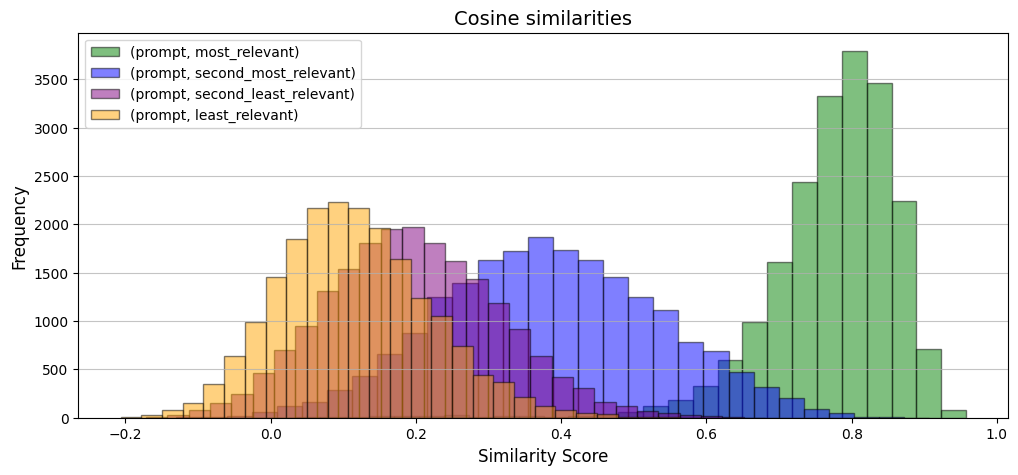

In [81]:
most_relevant_similarity = df["similarity_score"][df["class"] == 3]
second_most_relevant_similarity = df["similarity_score"][df["class"] == 2]
second_least_relevant_similarity = df["similarity_score"][df["class"] == 1]
least_relevant_similarity = df["similarity_score"][df["class"] == 0]

plt.figure(figsize=(12, 5))  # Adjust width and height as needed
plt.hist(most_relevant_similarity_train, bins=30, color='green', edgecolor='black', alpha=0.5, label='(prompt, most_relevant)')
plt.hist(second_most_relevant_similarity_train, bins=30, color='blue', edgecolor='black', alpha=0.5, label='(prompt, second_most_relevant)')
plt.hist(second_least_relevant_similarity_train, bins=30, color='purple', edgecolor='black', alpha=0.5, label='(prompt, second_least_relevant)')
plt.hist(least_relevant_similarity_train, bins=30, color='orange', edgecolor='black', alpha=0.5, label='(prompt, least_relevant)')
plt.title('Cosine similarities', fontsize=14)
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

### Shuffle rows

In [24]:
df = shuffle(df, random_state=42)
df = df.reset_index(drop=True)

In [26]:
df.head(5)

,prompt,text,class,similarity_score
0,Write a systematic survey or overview about th...,Title\nSparse Neural Networks With Large Learn...,1,0.159316
1,Write a systematic survey or overview about th...,Title\nPhotoredox catalysis by [Ru(bpy)3]2+ to...,3,0.856843
2,Write a systematic survey or overview about th...,Title\nComputation of geographic variables for...,3,0.828602
3,Write a systematic survey or overview about th...,Title\nMaking up a Region: The Rise and Fall o...,0,0.154820
4,Write a systematic survey or overview about th...,Title\nWhen cell biology meets development: en...,0,-0.043253


### Train / Test split

In [27]:
df_train, df_test = train_test_split(df, train_size=0.8, random_state=42)

In [84]:
df_train.shape

(80524, 5)

In [82]:
df_test.shape

(20132, 5)

### Find best tresholds using Train set
Note: for the first loop (outer loop), we range from min_value to (max_value - 2 * step) instead of (max_value) just to keep enough space (2 * step) between the first threshold and the max_value to fit the other two thresholds. A similar approach is taken for the second loop, where we keep a space of (1 * step) to fit the last threshold above it.

We could set all three higher limits to max_value and it would not change the results, we would just have some iterations where the values of the thresholds overlap:

($threshold_{1} = threshold_{2} = threhold_{3}$)

In [102]:
df_train["prediction"] = ''
tresholds = []
k_taus = []
min_value = round(df_train["similarity_score"].min(), 1)
max_value = round(df_train["similarity_score"].max(), 1)
step = 0.025
for i in np.arange(min_value, (max_value - 2*step), step):
    for j in np.arange(i+step, (max_value - step), step):
        for k in np.arange(j+step, max_value, step):
            df_train.loc[df_train["similarity_score"] <= i, "prediction"] = 0
            df_train.loc[(df_train["similarity_score"] > i) & (df_train["similarity_score"] <= j), "prediction"] = 1
            df_train.loc[(df_train["similarity_score"] > j) & (df_train["similarity_score"] <= k), "prediction"] = 2
            df_train.loc[df_train["similarity_score"] > k, "prediction"] = 3
            k_tau, _ = kendalltau(df_train["class"], df_train["prediction"])
            tresholds.append([round(i, 3), round(j, 3), round(k, 3)])
            k_taus.append(k_tau)

In [103]:
idx = np.nanargmax(k_taus)
print(f"Best tresholds: {tresholds[idx]}")
print(f"Train set Kendall's Tau: {round(k_taus[idx], 3)}")

Best tresholds: [0.275, 0.575, 0.625]
Train set Kendall's Tau: 0.775


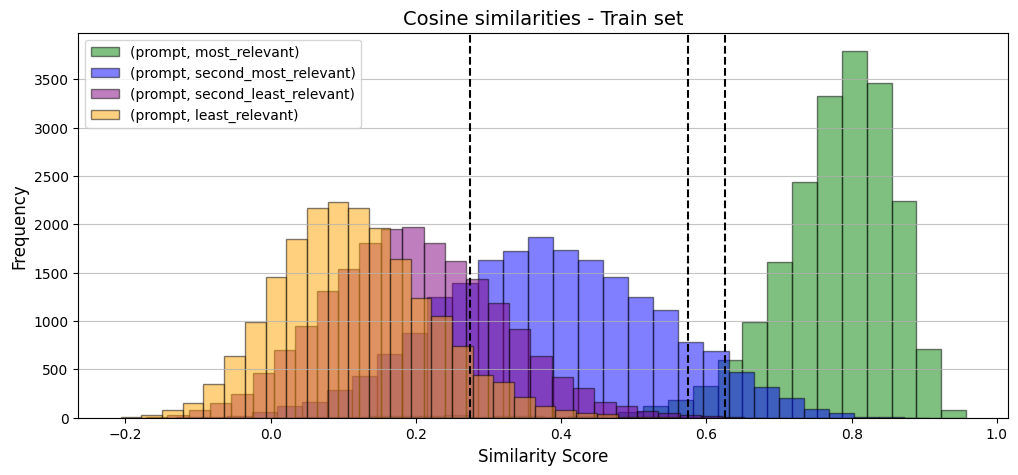

In [104]:
most_relevant_similarity_train = df_train["similarity_score"][df_train["class"] == 3]
second_most_relevant_similarity_train = df_train["similarity_score"][df_train["class"] == 2]
second_least_relevant_similarity_train = df_train["similarity_score"][df_train["class"] == 1]
least_relevant_similarity_train = df_train["similarity_score"][df_train["class"] == 0]

i = tresholds[idx][0]
j = tresholds[idx][1]
k = tresholds[idx][2]

plt.figure(figsize=(12, 5))  # Adjust width and height as needed
plt.hist(most_relevant_similarity_train, bins=30, color='green', edgecolor='black', alpha=0.5, label='(prompt, most_relevant)')
plt.hist(second_most_relevant_similarity_train, bins=30, color='blue', edgecolor='black', alpha=0.5, label='(prompt, second_most_relevant)')
plt.hist(second_least_relevant_similarity_train, bins=30, color='purple', edgecolor='black', alpha=0.5, label='(prompt, second_least_relevant)')
plt.hist(least_relevant_similarity_train, bins=30, color='orange', edgecolor='black', alpha=0.5, label='(prompt, least_relevant)')
plt.axvline(x=i, color='black', linestyle='--')
plt.axvline(x=j, color='black', linestyle='--')
plt.axvline(x=k, color='black', linestyle='--')
plt.title('Cosine similarities - Train set', fontsize=14)
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

### Prediction on Test set
Here we use the optimal values found for the thresholds: i, j and k

In [105]:
df_test["prediction"] = ''
df_test.loc[df_test["similarity_score"] <= i, "prediction"] = 0
df_test.loc[(df_test["similarity_score"] > i) & (df_test["similarity_score"] <= j), "prediction"] = 1
df_test.loc[(df_test["similarity_score"] > j) & (df_test["similarity_score"] <= k), "prediction"] = 2
df_test.loc[df_test["similarity_score"] > k, "prediction"] = 3
k_tau, _ = kendalltau(df_test["class"], df_test["prediction"])

In [106]:
print(f"Test set Kendall's Tau: {round(k_tau, 3)}")

Test set Kendall's Tau: 0.774


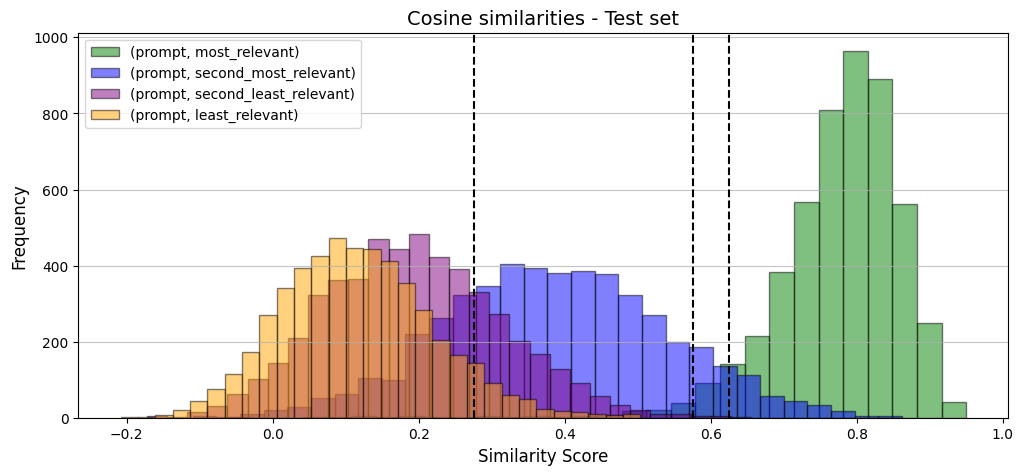

In [107]:
most_relevant_similarity_test = df_test["similarity_score"][df_test["class"] == 3]
second_most_relevant_similarity_test = df_test["similarity_score"][df_test["class"] == 2]
second_least_relevant_similarity_test = df_test["similarity_score"][df_test["class"] == 1]
least_relevant_similarity_test = df_test["similarity_score"][df_test["class"] == 0]

i = tresholds[idx][0]
j = tresholds[idx][1]
k = tresholds[idx][2]

plt.figure(figsize=(12, 5))  # Adjust width and height as needed
plt.hist(most_relevant_similarity_test, bins=30, color='green', edgecolor='black', alpha=0.5, label='(prompt, most_relevant)')
plt.hist(second_most_relevant_similarity_test, bins=30, color='blue', edgecolor='black', alpha=0.5, label='(prompt, second_most_relevant)')
plt.hist(second_least_relevant_similarity_test, bins=30, color='purple', edgecolor='black', alpha=0.5, label='(prompt, second_least_relevant)')
plt.hist(least_relevant_similarity_test, bins=30, color='orange', edgecolor='black', alpha=0.5, label='(prompt, least_relevant)')
plt.axvline(x=i, color='black', linestyle='--')
plt.axvline(x=j, color='black', linestyle='--')
plt.axvline(x=k, color='black', linestyle='--')
plt.title('Cosine similarities - Test set', fontsize=14)
plt.xlabel('Similarity Score', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(axis='y', alpha=0.75)
plt.legend()
plt.show()

### Save predictions to bootstrap later and compare with other baselines

In [108]:
df_save = df_test[["class", "prediction"]].reset_index(drop=True)
df_save.to_csv(r"C:\Users\Paulo Couto\Desktop\Master Paris-Saclay\Sujets\Creation of AI Challenge\New\Tresholds_Predictions.csv", index=False)
df_save.head(5)

,class,prediction
0,0,0
1,2,1
2,1,0
3,3,3
4,1,0
